# Image classification with multilayer perceptron (MLP)

**Name**:

In this lab we design and train our first MLP network, and we use it for image classification.

In [51]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision
import os
import matplotlib.pyplot as plt
import copy

## Dataset

We use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which is a large image dataset of hand-written digits.

<center><a href="https://en.wikipedia.org/wiki/MNIST_database">
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></a></center>

Just like some other widely-used datasets, MNIST can be downloaded directly from Pytorch, and includes specific commands to create a `Dataset` object, thus you don't have to do it manually as we did in lab 1.

In [52]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Choose one (or several) transform(s) to preprocess the data
# Here, we transform it to torch tensors, and we apply some normalization
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Create a Dataset (you can download the data by setting 'download=True')
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)
print('Number of classes in the dataset:', num_classes)

# We are not going to work with the full dataset (which is quite large), so we only keep small train and test subsets.
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(test_data, torch.arange(50))
print('Number of images in the train dataset', len(train_data))
print('Number of images in the test dataset', len(test_data))

Number of classes in the dataset: 10
Number of images in the train dataset 500
Number of images in the test dataset 50


torch.Size([1, 28, 28])
Image label= 5


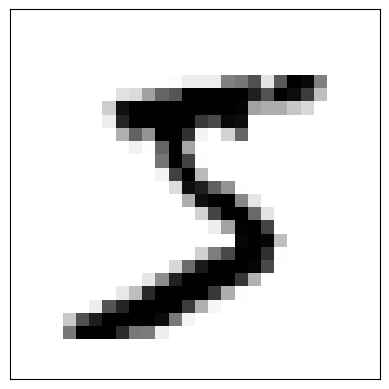

In [53]:
# Fetch one data pair (one image and the corresponding label)
image, label = train_data[0]
print(image.shape)
print('Image label=', label)

# The size of the image is [1, 28, 28], which corresponds to [num_channels, height, width]
# Indeed, MNIST images are in black-and-white (or grey scale) so there is only 1 color channel.
# To plot this image, let's remove this channel dimension by using squeeze()
plt.figure()
plt.imshow(image.squeeze(), cmap='gray_r')
plt.xticks([]), plt.yticks([])
plt.show()

In [54]:
# TO DO:
# - create two dataloaders (for the training and testing subsets) with a batch size of 8
# - print the number of batches in the training subset
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # for evalution no need to change the order
num_batches = len(train_dataloader)

print('Num of batches in the train subset:', num_batches)

Num of batches in the train subset: 63


In [55]:
# Get a batch of images and corresponding labels from the train dataloader
batch_example = next(iter(train_dataloader))
image_batch_example = batch_example[0]
labels_batch_example = batch_example[1]

# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8])


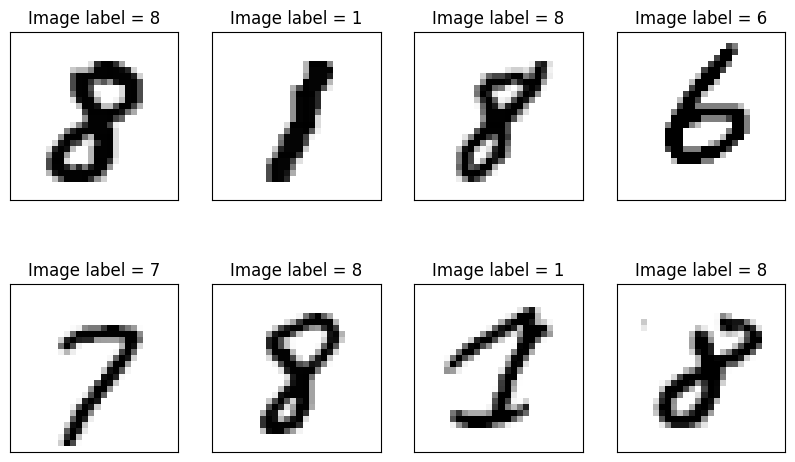

In [56]:
# Plot the images in the batch (along with the corresponding label)
plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## MLP network

A typical MLP network is composed of several layers:

- an *input* layer, which takes a batch of vectors and computes the first hidden representation.
- one or several *hidden* layers.
- an *output* layer, which computes the output of the network.

Each layer consists of a linear part and a non-linear *activation* functions (remember lab 2). There are many non-linear activation functions in Pytorch, check the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for a complete overview. A network is said to be *deep* if it has at least 3 layers (input, at least one hidden, and output).

<center><a href="https://www.researchgate.net/publication/309592737_Classification_of_VoIP_and_non-VoIP_traffic_using_machine_learning_approaches">
    <img src="https://www.researchgate.net/profile/Mouhammd-Alkasassbeh/publication/309592737/figure/fig2/AS:423712664100865@1478032379613/MultiLayer-Perceptron-MLP-sturcture-334-MultiLayer-Perceptron-Classifier-MultiLayer.png"></a></center>

**Note**: Since an MLP manipulates vectors (= 1D-tensors) as inputs, in image processing we first have to transform our images into vectors. For instance, if a black-and-white image is a (3D) tensor of size `[1, 28, 28]`, then we have to reshape it into a tensor of size `[1x28x28] = [784]`.


### Example

First, let's write each layer individually and apply them on the example batch `image_batch_example`.

In [57]:
# TO DO: reshape image_batch_example into a batch of vectors (=vectorized images):
# 'image_batch_example' has size [batch_size, 1, 28, 28]
# 'vectorized_batch' should have size [batch_size, 1*28*28]
batch_size = image_batch_example.size(0)  # get batch size
vectorized_batch = image_batch_example.reshape(batch_size, -1)
vectorized_batch.shape

torch.Size([8, 784])

In [58]:
# Now we create the input layer (linear and activation) and we pass the vectorized batch through it
input_size = vectorized_batch.shape[-1]
hidden_size = 10
input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.Sigmoid())
y = input_layer(vectorized_batch)
print(y.shape)

torch.Size([8, 10])


Now, let's create the hidden and output layers.
- the hidden layer goes from `hidden_size` to `hidden_size`, and uses a Sigmoid activation function.
- the output layer goes from `hidden_size` to `output_size`, and uses no activation function.

**Note**: the output size is the number of classes in the dataset.

In [59]:
# TO DO:
# - create the hidden and output layers
# - apply them to y to compute the output 'out'
# - print the size of 'out'

#output size
num_classes = len(train_data.dataset.classes)
num_classes

10

In [60]:
# hidden layer
hidden_layer = nn.Sequential(
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid()
)
hidden_layer

Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): Sigmoid()
)

In [61]:
# output layer with no activation function
output_layer = nn.Linear(hidden_size, num_classes)
output_layer

Linear(in_features=10, out_features=10, bias=True)

In [62]:
# apply hidden layer
y_hidden = hidden_layer(y)
# apply the output layer to y_hidden
out = output_layer(y_hidden)
print('Shape of out:', out.shape)

Shape of out: torch.Size([8, 10])


From what we have done above, two important remarks can be made:

- The output `out` has size `[batch_size, num_classes]` while the true labels `labels_batch_example` has size `[batch_size]`. This is because `out` contains a predicted probability for each class, while `labels_batch_example` simply contains the true labels.
- In classification tasks, we want to output *probabilities per class*. However, nothing ensures that `out` corresponds to probabilities, since it is not normalized and we didn't use any output activation function (values can be negative and not sum up to 1).

However, when training a classification network, we generally use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) loss function, which alleviates these two issues. This loss is optimized for handling true labels instead of true probabilities per class, so you don't have to worry about it. Besides, it will automatically apply a [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) non-linearity to the predicted outputs, in order to normalize them as probabilities per class.

**Note**: Instead of Cross Entropy, you can use the [Negative log-likelihood](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) similarly. It will also solve the first problem, but then you need to manually add a [log Softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) as output activation to normalize the outputs.

In [63]:
# Choose Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()

# Compute the error between the predicted labels 'out' and true labels 'labels_batch_example'
loss_batch = loss_fn(out, labels_batch_example)
print(loss_batch.item())

2.2376537322998047


### General module

Now, let's create a general MLP classification network. It's a python class that inherits from the general `nn.Module` object, and it should contain at least 2 methods:

- `__init__`, which initializes the network when instanciated (creates all the layers and stores some useful parameters if needed).
- `forward`, which applies the forward pass (i.e., applies the layers to the input in order to compute the output).

You can add other methods if needed but these two are sufficient for now.

**Note**: Remember that Python classes usually define and use some variables/data/tensors/dictionary etc. internally (this includes network layers) called *attributes*: they should be defined in the `__init__` method with a specific structure (the name should start by `self.`, as we did in lab 1). This allows you to access these attributes in other methods, such as *forward*, or after defining your network.

In [64]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super().__init__() # inherits methods from the parent class (= nn.Module)
        
        self.act_fn = act_fn()
        # input layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            self.act_fn
        )
        # hidden layer
        self.hidden_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            self.act_fn  
        )
        # output layer without act function
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        
        # TO DO: write the 'forward' method, which computes the output 'out' from the input x
        # It should apply the input, hidden, and output layer, as we did in the example before.
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        out = self.output_layer(x)
        
        return out

<span style="color:red">**Exercice 1**</span> Instanciate an MLP classifier with a hidden size of 10 and a Sigmoid activation function. Use the provided function below to print the number of parameters in the model.

In [65]:
def print_num_params(model):
    print('Total number of parameters:', sum(p.numel() for p in model.parameters()))
    return

In [66]:
input_size = 28 * 28  # 784
output_size = 10      # number of classes 

model = MLPClassif(input_size, hidden_size=10, output_size=output_size, act_fn=nn.Sigmoid)
# number of params
print_num_params(model)

Total number of parameters: 8070


### Initialization

It is important to properly initialize the network's parameters: this allows for reproducibity (avoid randomness), and might have a strong impact on the training process / final performance.

In [67]:
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

model.apply(init_params)

MLPClassif(
  (act_fn): Sigmoid()
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)

In [68]:
# # Also remember (cf. lab 2) that you can save / load the model's parameters as follows:
# torch.save(model.state_dict(), 'model_mlp_classif.pt')
# model = MLPClassif(input_size, hidden_size, output_size, act_fn)
# model.load_state_dict(torch.load('model_mlp_classif.pt'))

## Training

We now write the function for training the network. It's very similar to what we did in lab 2, except now we process batches of data instead of the whole dataset at each epoch.

In [69]:
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list for storing the training loss over epochs
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        
        # Initialize the training loss for the current epoch
        tr_loss = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorize the images
            # - calculate the predicted labels from the vectorized images using 'model_tr'
            # - using loss_fn, calculate the 'loss' between the predicted and true labels
            # - set the optimizer gradients at 0 for safety
            # - compute the gradients (use the 'backward' method on 'loss')
            # - apply the gradient descent algorithm (perform a step of the optimizer)
            
            # reshape images 
            batch_size = images.size(0)
            vectorized_images = images.view(batch_size, -1)

            outputs = model_tr(vectorized_images)  # get predictions
            loss = loss_fn(outputs, labels)  # loss b/w predicted and actual labels
            optimizer.zero_grad()  # zero gradients
            loss.backward()  # compute gradient
            optimizer.step()  # update parameters
            
            # For each batch, we update the current epoch loss
            tr_loss += loss.item()

        # At the end of each epoch, get the average training loss over all batches
        tr_loss = tr_loss / len(train_dataloader)
        train_losses.append(tr_loss)
        
        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))
    
    return model_tr, train_losses

In [70]:
# TO DO: Define the training parameters and train the model
# - 30 epochs
# - learning rate = 0.01
# - loss function: Cross Entropy
# After training, save the model parameters and display the loss over epochs

num_epochs = 30
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()

trained_model, training_losses = training_mlp_classifier(
    model,          # MLP model
    train_loader,   # DataLoader for the training data
    num_epochs,     
    loss_fn,        
    learning_rate,  
    verbose=True 
)
torch.save(trained_model.state_dict(), 'model_mlp_classif.pt')  # save the model params

Epoch [1/30], Training loss: 2.3428
Epoch [2/30], Training loss: 2.3028
Epoch [3/30], Training loss: 2.2734
Epoch [4/30], Training loss: 2.2532
Epoch [5/30], Training loss: 2.2375
Epoch [6/30], Training loss: 2.2236
Epoch [7/30], Training loss: 2.2107
Epoch [8/30], Training loss: 2.2001
Epoch [9/30], Training loss: 2.1877
Epoch [10/30], Training loss: 2.1756
Epoch [11/30], Training loss: 2.1632
Epoch [12/30], Training loss: 2.1522
Epoch [13/30], Training loss: 2.1398
Epoch [14/30], Training loss: 2.1309
Epoch [15/30], Training loss: 2.1186
Epoch [16/30], Training loss: 2.1069
Epoch [17/30], Training loss: 2.0970
Epoch [18/30], Training loss: 2.0857
Epoch [19/30], Training loss: 2.0738
Epoch [20/30], Training loss: 2.0629
Epoch [21/30], Training loss: 2.0501
Epoch [22/30], Training loss: 2.0401
Epoch [23/30], Training loss: 2.0282
Epoch [24/30], Training loss: 2.0165
Epoch [25/30], Training loss: 2.0041
Epoch [26/30], Training loss: 1.9908
Epoch [27/30], Training loss: 1.9781
Epoch [28/

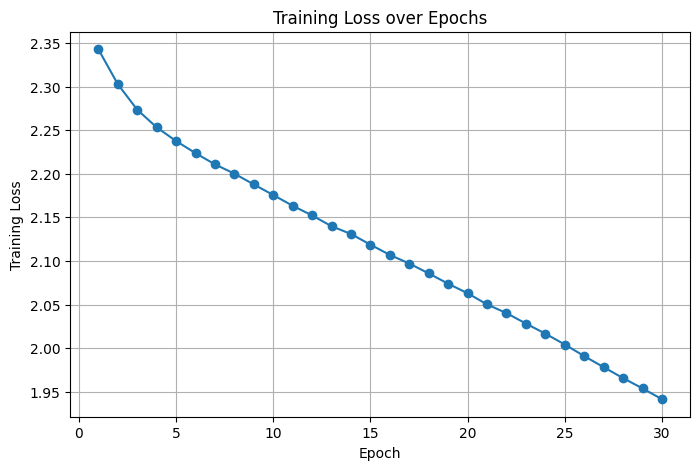

In [71]:
# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), training_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

## Evaluation

Now the model is trained, we can evaluate it on the test dataset. We do that by predicting the labels using our model, and comparing it with the true labels. This allows us to compute the classification accuracy, which is provided in the function below.

<span style="color:red">**Exercice 2**</span> Evaluate the model on the test set. To do that, instanciate an MLP newtork and load the trained parameters. Then, apply the evaluation function using the test dataloader, and print the accuracy. Based on the plot above (training loss over epochs), can you suggest a way to improve the test accuracy?

In [72]:
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop
def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode: this disables some layers (batch norm, dropout...) which are not needed when testing
    model.eval()

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [74]:
act_fn = nn.Sigmoid

# instantiate new classifier
model = MLPClassif(input_size, hidden_size, output_size, act_fn)
# load trained params
model.load_state_dict(torch.load('model_mlp_classif.pt'))
# evaluate on test data
accuracy = eval_mlp_classifier(model, test_loader)
accuracy

52.0

## Influence of the activation function

We used the MLP classifier with a Sigmoid activation function, but another common choice is the [Rectified Linear Unit](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU). Here we investigate how it performs compared to the Sigmoid-based network.

<span style="color:red">**Exercice 3**</span> Define an MLP classifier using ReLU activation, and initialize it. Train it (plot the training loss over epochs), and compute the test accuracy. Which one (Sigmoid or ReLU) do you recommend to use?

In [75]:
input_size = 28 * 28  
hidden_size = 10      
output_size = 10 

# ReLU activation func
act_fn = nn.ReLU

relu_model = MLPClassif(input_size, hidden_size, output_size, act_fn)
# Initialization of parameters
relu_model.apply(init_params)

MLPClassif(
  (act_fn): ReLU()
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)

In [76]:
num_epochs = 30
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()

# Train model
trained_relu_model, relu_training_losses = training_mlp_classifier(
    relu_model,     
    train_loader,   
    num_epochs,     
    loss_fn,        
    learning_rate,  
    verbose=True    
)
torch.save(trained_relu_model.state_dict(), 'model_mlp_classif_relu.pt')

Epoch [1/30], Training loss: 2.0288
Epoch [2/30], Training loss: 1.5568
Epoch [3/30], Training loss: 1.2553
Epoch [4/30], Training loss: 1.0033
Epoch [5/30], Training loss: 0.8059
Epoch [6/30], Training loss: 0.6556
Epoch [7/30], Training loss: 0.5563
Epoch [8/30], Training loss: 0.4734
Epoch [9/30], Training loss: 0.4047
Epoch [10/30], Training loss: 0.3500
Epoch [11/30], Training loss: 0.2996
Epoch [12/30], Training loss: 0.2707
Epoch [13/30], Training loss: 0.2334
Epoch [14/30], Training loss: 0.2147
Epoch [15/30], Training loss: 0.1820
Epoch [16/30], Training loss: 0.1659
Epoch [17/30], Training loss: 0.1462
Epoch [18/30], Training loss: 0.1320
Epoch [19/30], Training loss: 0.1212
Epoch [20/30], Training loss: 0.1099
Epoch [21/30], Training loss: 0.1018
Epoch [22/30], Training loss: 0.0935
Epoch [23/30], Training loss: 0.0857
Epoch [24/30], Training loss: 0.0810
Epoch [25/30], Training loss: 0.0731
Epoch [26/30], Training loss: 0.0675
Epoch [27/30], Training loss: 0.0626
Epoch [28/

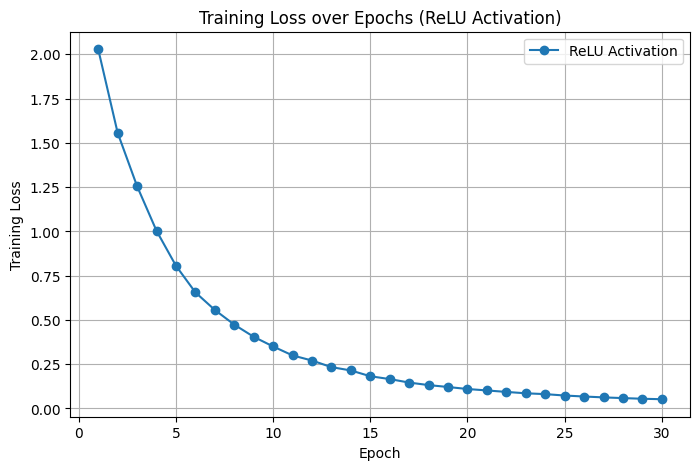

In [77]:
# Plot the training loss over epochs for the ReLU model
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), relu_training_losses, marker='o', label='ReLU Activation')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs (ReLU Activation)')
plt.grid(True)
plt.legend()
plt.show()

In [80]:
# Evaluate the ReLU model on the test set
relu_accuracy = eval_mlp_classifier(trained_relu_model, test_loader)
relu_accuracy 

80.0

I recommend ReLU. The model using the ReLU activation function achieved higher accuracy. The steeper slope of the training loss curve for the ReLU model shows that it converged more quickly, finding the best parameters faster. 

## Increasing the model capacity

In order to improve performance, a straightforward approach is to increase the model capacity, i.e., increase the number of parameters. There are basically two ways to do so: either increase the number of neurons in each layer (*width*) of increase the total number of layers (*depth*). Let's focus here on width.

<span style="color:red">**Exercice 4**</span> For each value of `hidden_size` in $[5, 10, 100, 200]$:
- instanciate (and initialize) an MLP classifier (it uses a ReLU activation)
- train the network (same training setup as before)
- print the number of parameters
- compute and display the test accuracy

Which value of `hidden_size` would you use and why?

In [81]:
 def print_num_params(model):
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total number of parameters: {total_params}")
        return total_params


Adjusting of hidden_size 5

Total number of parameters: 4015


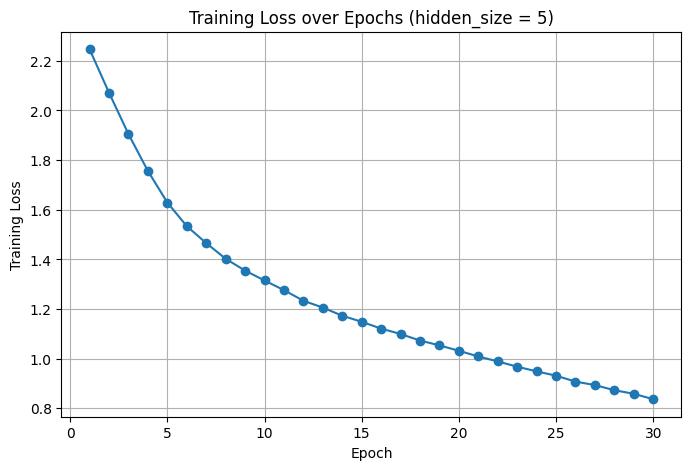

Test accuracy: 64.00%

Adjusting of hidden_size 10

Total number of parameters: 8070


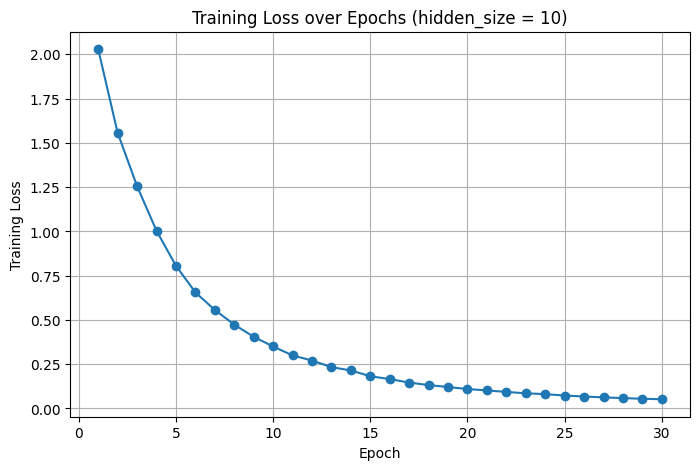

Test accuracy: 80.00%

Adjusting of hidden_size 100

Total number of parameters: 89610


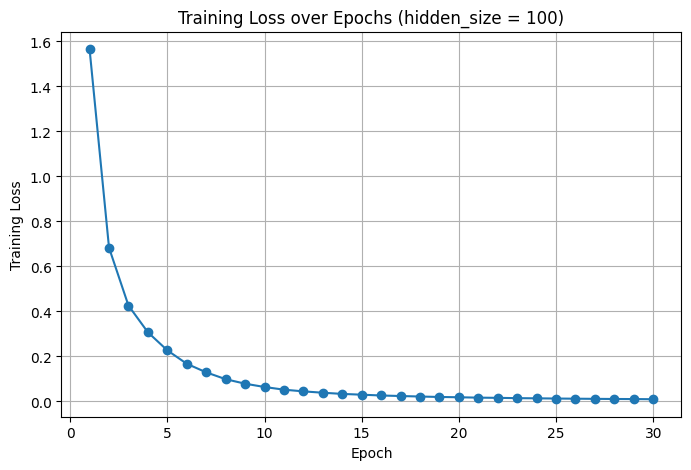

Test accuracy: 92.00%

Adjusting of hidden_size 200

Total number of parameters: 199210


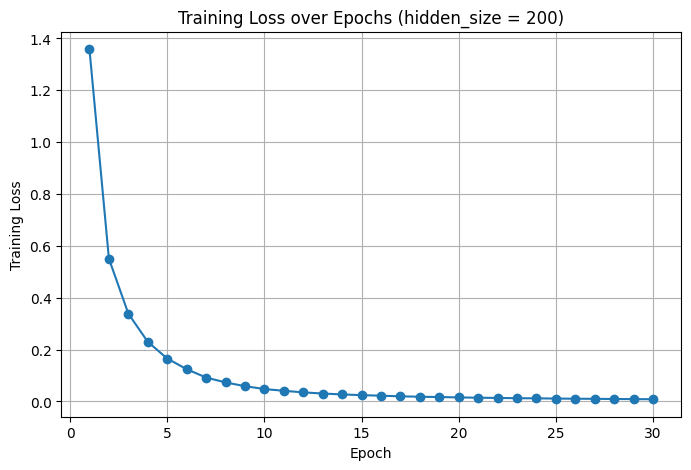

Test accuracy: 92.00%

Adjusting of hidden_size 300

Total number of parameters: 328810


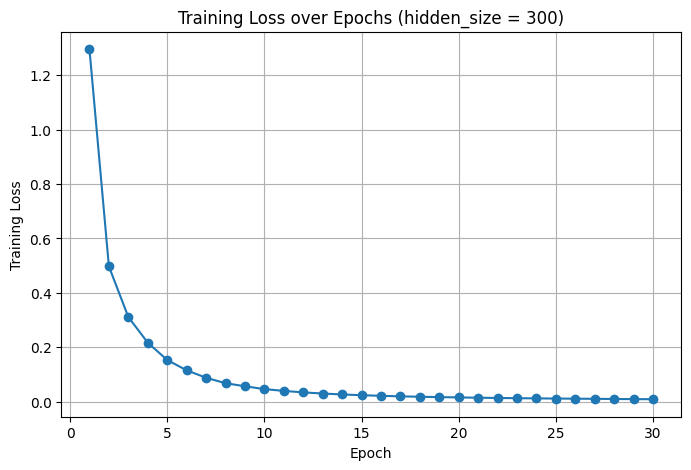

Test accuracy: 96.00%

Adjusting of hidden_size 400

Total number of parameters: 478410


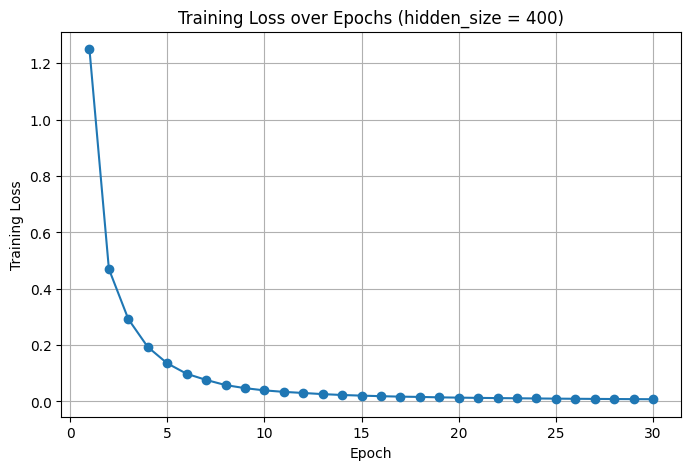

Test accuracy: 92.00%

Adjusting of hidden_size 500

Total number of parameters: 648010


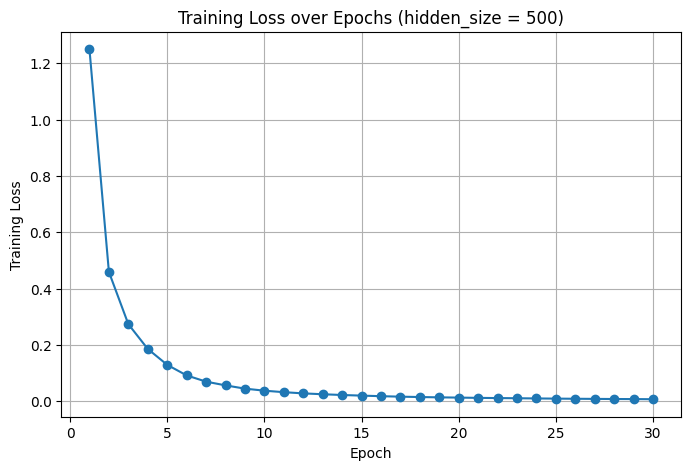

Test accuracy: 92.00%


In [84]:
hidden_sizes = [5, 10, 100, 200, 300, 400, 500]
comparisons = []

for hidden_size in hidden_sizes:
    print(f"\nAdjusting of hidden_size {hidden_size}\n")
    
    model = MLPClassif(input_size, hidden_size, output_size, act_fn)
    model.apply(init_params)
    
    # number of parameters
    total_params = print_num_params(model)
    
    # train the model
    trained_model, training_losses = training_mlp_classifier(
        model,
        train_loader,
        num_epochs,
        loss_fn,
        learning_rate,
        verbose=False
    )
    
    # plot the training loss over epochs
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), training_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'Training Loss over Epochs (hidden_size = {hidden_size})')
    plt.grid(True)
    plt.show()
    
    # evaluate accuracy
    accuracy = eval_mlp_classifier(trained_model, test_loader)
    print(f"Test accuracy: {accuracy:.2f}%")
    
    comparisons.append({
        'hidden_size': hidden_size,
        'total_params': total_params,
        'test_accuracy': accuracy,
        'training_losses': training_losses
    })

The hidden size=300 provides the best performance with a test accuracy=96%. It significantly boosts accuracy compared to smaller sizes. It also outperforms larger hidden sizes, which added more parameters but didn't lead to further improvements in accuracy.The model becomes prone to overfitting and, possibly, memorize instead of learning.